In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
print_tensor = lambda n, x: print(n, type(x), x.shape, x.min(), x.max())
print(sys.path)
# from pathlib import Pathth


['/home/dejuns/git/mmdet4med/demo', '/home/dejuns/.vscode-server/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/home/dejuns/.vscode-server/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/home/dejuns/miniconda3/lib/python38.zip', '/home/dejuns/miniconda3/lib/python3.8', '/home/dejuns/miniconda3/lib/python3.8/lib-dynload', '', '/home/dejuns/miniconda3/lib/python3.8/site-packages', '/home/dejuns/git/mmseg4med', '/home/dejuns/miniconda3/lib/python3.8/site-packages/ribfrac-1.0.0-py3.8.egg', '/home/dejuns/git/nnDetection', '/home/dejuns/git/mmdet4med', '/home/dejuns/miniconda3/lib/python3.8/site-packages/IPython/extensions', '/home/dejuns/.ipython', '/home/dejuns/git/mmdet4med']


In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from demo.visual_gt_pred import *
import re
import mmcv

# # load data from a file-like object, supporting json, yaml and pickle.
# with open('test.json', 'r') as f:
#     data = mmcv.load(f, file_format='json')
# # dump data to a string
# json_str = mmcv.dump(data, file_format='json')
# mmcv.list_from_file('a.txt')

In [8]:
tb_rt = Path('/data/lung_algorithm/data/DetFrac/processed_new/plan_rib_crop')

cohortids = [a for a in os.listdir(tb_rt) if os.path.isdir(tb_rt/a)]

roi_all_list = []
for cohort in cohortids:
    cohort_dir = tb_rt/cohort
    cids = os.listdir(cohort_dir)
    
    for cid in cids:
        roi_fp = cohort_dir/f'{cid}/{cid}_ins2cls.json'
        with open(roi_fp, 'r') as f:
            roi_info = mmcv.load(f, file_format='json')
        for roi in roi_info: 
            roi['cohort'] = cohort
            roi['cid'] = cid
            roi['size'] = np.linalg.norm(np.array(roi['bbox'])[3:] - np.array(roi['bbox'])[:3])
        roi_all_list.extend(roi_info)

roi_all_tb = pd.DataFrame(roi_all_list)
roi_all_tb['source'] = roi_all_tb['cohort'].apply(lambda x: 'ky' if 'KY' in x else 'pub')
roi_all_tb.info()
roi_all_tb.to_csv(tb_rt/'fracture_instance_info_all.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6238 entries, 0 to 6237
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bbox            6238 non-null   object 
 1   center          6238 non-null   object 
 2   class           6238 non-null   int64  
 3   instance        6238 non-null   int64  
 4   spine_boundary  6238 non-null   object 
 5   cohort          6238 non-null   object 
 6   cid             6238 non-null   object 
 7   size            6238 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 390.0+ KB


,bbox,center,class,instance,spine_boundary,cohort,cid,size
0,"[88, 63, 120, 106, 80, 136]","[97, 72, 128]",4,1,"[201, 265, 193, 292]",KY_B3_20_crop,3762676,29.478806
1,"[105, 47, 149, 123, 69, 163]","[113, 57, 155]",3,2,"[201, 265, 193, 292]",KY_B3_20_crop,3762676,31.685959
2,"[81, 171, 209, 97, 199, 220]","[89, 183, 214]",4,1,"[208, 265, 186, 292]",KY_B3_20_crop,1614752,34.073450
3,"[276, 282, 97, 297, 295, 108]","[285, 288, 102]",1,1,"[209, 275, 223, 324]",KY_B3_20_crop,1288841,27.037012
4,"[418, 76, 111, 440, 91, 118]","[429, 83, 114]",2,1,"[232, 296, 206, 303]",KY_B3_20_crop,1775362,27.531800


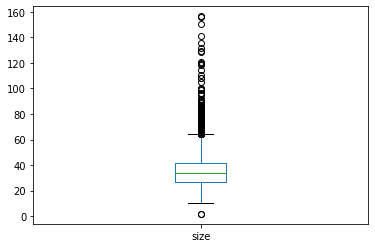

In [40]:
# roi_all_tb['size'].hist(bins = 40, by= roi_all_tb['class'], layout = (1, 4), figsize=(12, 3))
ax = roi_all_tb['size'].plot.box(by= roi_all_tb['class'])


array([<AxesSubplot:title={'center':'ky'}>,
       <AxesSubplot:title={'center':'pub'}>], dtype=object)

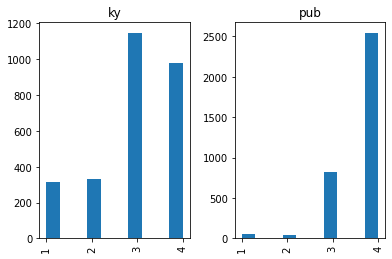

In [14]:

roi_all_tb['class'].hist(by= roi_all_tb['source'])


In [15]:
cls_by_source = pd.crosstab(roi_all_tb['class'], roi_all_tb['source'])
print(cls_by_source)

source    ky   pub
class             
1        314    52
2        331    44
3       1148   827
4        977  2545


Num fracture keya 2770
Num fracture pub 3468


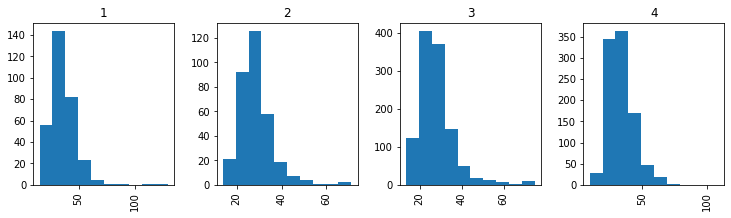

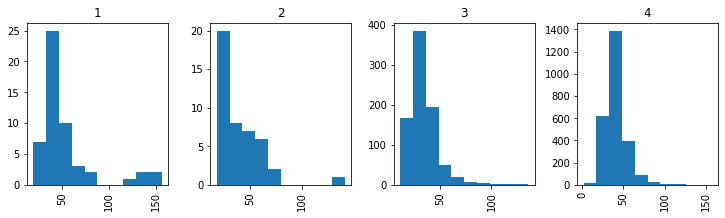

In [39]:
roi_info_ky = roi_all_tb.loc[roi_all_tb['source'] == 'ky', :]
roi_info_pub = roi_all_tb.loc[roi_all_tb['source'] == 'pub', :]

roi_info_ky['size'].hist(by= roi_info_ky['class'], layout = (1, 4), figsize=(12, 3))
roi_info_pub['size'].hist(by= roi_info_pub['class'], layout = (1, 4), figsize=(12, 3))

print('Num fracture keya', len(roi_info_ky))
print('Num fracture pub', len(roi_info_pub))

In [22]:
pid_base_infos = pd.pivot_table(roi_all_tb, index = ['cid', 'cohort', 'source'], values = 'instance', aggfunc=lambda x: len(x))
pid_base_infos.reset_index(inplace = True)
print(pid_base_infos.info())
print(pid_base_infos.describe())
# pred_case_tb = pd.pivot_table(pred_nodes_tb,index = ['pid', 'date_num', 'sub_dir'],
#                                           # columns = [''],
#                                           values = 'node_type',
#                                           aggfunc=lambda x:len(x))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1173 entries, 0 to 1172
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   cid       1173 non-null   object
 1   cohort    1173 non-null   object
 2   source    1173 non-null   object
 3   instance  1173 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 36.8+ KB
None
          instance
count  1173.000000
mean      5.317988
std       4.376519
min       1.000000
25%       2.000000
50%       4.000000
75%       7.000000
max      32.000000


array([<AxesSubplot:title={'center':'ky'}>,
       <AxesSubplot:title={'center':'pub'}>], dtype=object)

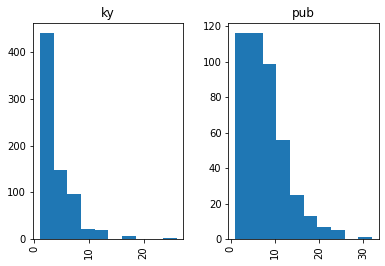

In [24]:
pid_base_infos['instance'].hist(by = pid_base_infos['source'])

In [37]:
# pib_ky_tb = pid_base_infos.loc[pid_base_infos['source'] == 'ky', :]
count_by_cohort = pid_base_infos['cohort'].value_counts()
print(count_by_cohort, sum(count_by_cohort))


ribfrac2020_crop    438
KY_B7_158_crop      158
KY_B9_150_crop      150
KY_B8_120_crop      120
KY_B5_74_crop        74
KY_B0_100_crop       73
KY_B6_48_crop        48
KY_B4_50_crop        48
KY_B1_30_crop        27
KY_B3_20_crop        20
KY_B2_20_crop        17
Name: cohort, dtype: int64 1173


AxesSubplot(0.125,0.125;0.775x0.755)


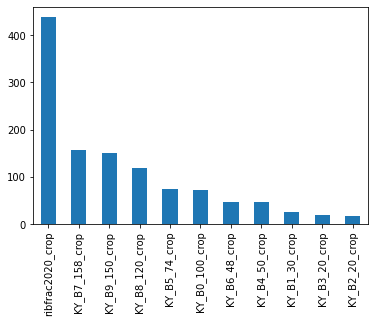

In [38]:
ax = count_by_cohort.plot.bar()
print(ax)